### Imports

In [1]:
%pip install transformer_lens huggingface_hub

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from transformer_lens import HookedTransformer
from transformer_lens.hook_points import HookPoint
from typing import Dict, List, Optional, Tuple, Union
import numpy as np
from dataclasses import dataclass
from tqdm.auto import tqdm
import requests
import zipfile
import os
import json
from pathlib import Path
from functools import partial
import copy
import matplotlib.pyplot as plt

from huggingface_hub import login
login()

## Probing

#### Loading datasets

In [3]:
# Label mappings
LABEL_MAPS = {
    "age": {
        "child": 0,
        "adolescent": 1,
        "adult": 2,
        "older adult": 3,
    },
    "gender": {
        "male": 0,
        "female": 1,
    },
    "socioeconomic": {
        "low": 0,
        "middle": 1,
        "high": 2
    },
    "education": {
        "someschool": 0,
        "highschool": 1,
        "collegemore": 2
    }
}

In [4]:
def load_dataset(
    attribute: str,
    version: str = "1"
) -> Tuple[List[str], List[int]]:
    """Load dataset for a given attribute"""
    if attribute == "education":
        data_path = Path(f"dataset/openai_{attribute}_three_classes_{version}.zip")
    else:
        data_path = Path(f"dataset/llama_{attribute}_{version}.zip")

    if not data_path.exists():
        print("Downloading dataset...")
        url = f"https://github.com/yc015/TalkTuner-chatbot-llm-dashboard/raw/main/data/dataset/{data_path.name}"
        response = requests.get(url)
        if response.status_code != 200:
            raise ValueError(f"Download failed: HTTP {response.status_code}")

        data_path.parent.mkdir(parents=True, exist_ok=True)
        with open(data_path, "wb") as f:
            f.write(response.content)

    # Extract if needed
    extract_path = data_path.parent / data_path.stem

    if not extract_path.exists():
        print("Extracting files...")
        with zipfile.ZipFile(data_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)

    texts = []
    labels = []
    label_map = LABEL_MAPS[attribute]

    # Process txt files
    for txt_file in extract_path.glob("*.txt"):
        # Extract label from filename (e.g., "conversation_107_age_adolescent.txt" -> "adolescent")
        label = txt_file.stem.split('_')[-1]

        if label in label_map:
            with open(txt_file) as f:
                text = f.read().strip()
            texts.append(text)
            labels.append(label_map[label])

    return texts, labels

#### Defining probes

In [5]:
class LinearProbes(nn.Module):
    def __init__(self, input_dim: int, num_classes: int):
        super().__init__()
        self.probe = nn.Linear(input_dim, num_classes)

        nn.init.xavier_uniform_(self.probe.weight)
        nn.init.zeros_(self.probe.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sigmoid(self.probe(x))

    def get_grouped_params(self):
        decay = []
        no_decay = []

        for name, param in self.named_parameters():
            if not param.requires_grad:
                continue
            if 'bias' in name:
                no_decay.append(param)
            else:
                decay.append(param)

        return [
            {'params': decay},
            {'params': no_decay, 'weight_decay': 0.0}
        ]


In [6]:
@dataclass
class ProbeConfig:
    """Configuration for probe training"""
    learning_rate: float = 1e-3
    betas: Tuple[float, float] = (0.9, 0.95)
    weight_decay: float = 0.1
    batch_size: int = 200
    num_epochs: int = 50
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

#### Getting activations

In [7]:
class ProbeDataset(Dataset):
    def __init__(self, model: HookedTransformer, texts: List[str], labels: List[int], num_classes: int, batch_size: int):
        self.model = model
        self.labels = torch.tensor(labels)
        self.num_classes = num_classes
        self.len = len(texts)
        self.batch_size = batch_size
        self.text_loader = DataLoader(texts, batch_size=batch_size, shuffle=False)

        self.activations = self._get_activations(texts)

    def _get_activations(self, texts: List[str]) -> List[torch.Tensor]:

        activations = [[] for _ in range(self.model.cfg.n_layers)]

        def hook_fn(resid: torch.Tensor, hook: HookPoint, layer: int) -> torch.Tensor:
            activations[layer].append(resid[:,-1].to('cpu'))
            return resid

        for batch in tqdm(self.text_loader):
            tokens = self.model.to_tokens(batch, prepend_bos=True, padding_side='left')
            with torch.no_grad():
                self.model.run_with_hooks(tokens,
                                          fwd_hooks=[(f'blocks.{layer}.hook_resid_post', partial(hook_fn, layer=layer)) for layer in range(self.model.cfg.n_layers)],
                                          return_type=None)

        for layer in range(self.model.cfg.n_layers):
            activations[layer] = torch.cat(activations[layer], dim=0)

        # shape: [n_layers, n_dataset, d_model]
        return torch.stack(activations)


    def __len__(self) -> int:
        return self.len

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        activation = self.activations[:,idx]
        label = torch.zeros(self.num_classes)
        label[self.labels[idx]] = 1.0
        return activation, label

#### Training probes

In [8]:
def train_eval_probe(
    model: HookedTransformer,
    probe: LinearProbes,
    train_loader: DataLoader,
    eval_loader: DataLoader,
    layer: int,
    config: ProbeConfig) :

    probe = probe.to(config.device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.AdamW(probe.get_grouped_params(),
                                  lr=config.learning_rate,
                                  betas=config.betas,
                                  weight_decay=config.weight_decay,
    )

    losses = []
    accuracies = []
    best_accuracy = 0
    best_probe = None

    for epoch in range(config.num_epochs):
        epoch_losses = []
        for activs, labels in train_loader:
            probe.train()
            activations = activs[:,layer].to(config.device)
            labels = labels.to(config.device)

            optimizer.zero_grad()
            outputs = probe(activations)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)

        # Eval and store top
        with torch.no_grad():
            probe.eval()
            total_correct = 0
            total_samples = 0
            for activs, labels in eval_loader:
                activations = activs[:,layer].to(config.device)
                labels = labels.to(config.device)

                outputs = probe(activations)
                predictions = outputs.argmax(dim=-1)
                true_labels = labels.argmax(dim=-1)

                total_correct += (predictions == true_labels).sum().item()
                total_samples += labels.size(0)

            accuracies.append(total_correct / total_samples)
            if accuracies[-1] > best_accuracy:
                best_accuracy = accuracies[-1]
                best_probe = copy.deepcopy(probe)

    return best_probe, losses, accuracies

#### Example

In [9]:
model = HookedTransformer.from_pretrained("gemma-2-2b-it", device="cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-2b-it into HookedTransformer


In [13]:
dataset_name = 'gender'

texts, labels = load_dataset(dataset_name)
num_classes = len(LABEL_MAPS[dataset_name])
config = ProbeConfig(batch_size=64)

probe_data = ProbeDataset(model, texts, labels, num_classes, 5)

## I might want to centre these activations here

train_size = int(0.8 * len(probe_data))
test_size = len(probe_data) - train_size

train_dataset, test_dataset = random_split(probe_data, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size)

Extracting files...


  0%|          | 0/60 [00:00<?, ?it/s]

In [18]:
accuracies = []
all_probes = []
for layer in tqdm(range(model.cfg.n_layers), desc="Probing layers"):

    probe = LinearProbes(model.cfg.d_model, num_classes)
    trained_probe, losses, accuracy = train_eval_probe(model, probe, train_loader, test_loader, layer, config)

    accuracies.append(max(accuracy))
    all_probes.append(trained_probe)

Probing layers:   0%|          | 0/26 [00:00<?, ?it/s]

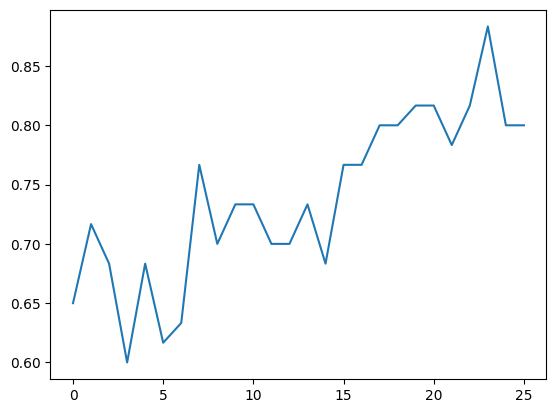

In [19]:
plt.plot(accuracies)

In [185]:
collected_probe_weights = torch.empty(0, num_classes, model.cfg.d_model)
collected_probe_bias = torch.empty(0, num_classes)
for probe in all_probes:
    collected_probe_weights = torch.cat((collected_probe_weights, probe.probe.weight[None, :, :].cpu()), 0)
    collected_probe_bias = torch.cat((collected_probe_bias, probe.probe.bias[None, :].cpu()), 0)

torch.save(collected_probe_weights, f"collected_{dataset_name}_probe_weights.pt")
torch.save(collected_probe_bias, f"collected_{dataset_name}_probe_biases.pt")

collected_probe_weights.shape, collected_probe_bias.shape

(torch.Size([26, 3, 2304]), torch.Size([26, 3]))